In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error


In [2]:
df = pd.read_csv('Advertising.csv')
df = df.drop(columns=['Unnamed: 0'])  
df.head()

,TV,radio,newspaper,sales
0,230.1,37.8,69.2,22.1
1,44.5,39.3,45.1,10.4
2,17.2,45.9,69.3,9.3
3,151.5,41.3,58.5,18.5
4,180.8,10.8,58.4,12.9


In [3]:
X = df[['TV', 'radio', 'newspaper']]
y = df['sales']

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

In [5]:
modelo = XGBRegressor(n_estimators=150,        
    max_depth=4,             
    max_leaves=10)
modelo.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=10,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=150, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [11]:
y_pred = modelo.predict(X_test)
mse = mean_squared_error(y_test, y_pred)

print("Error cuadrático medio (MSE):", round(mse, 3))

Error cuadrático medio (MSE): 0.868


In [13]:
r2 = modelo.score(X_test, y_test)
print("Coeficiente de determinación R²:", round(r2, 4))


Coeficiente de determinación R²: 0.9668


In [15]:
# 8. Calcular R² en train y test

r2_train = modelo.score(X_train, y_train)
r2_test = modelo.score(X_test, y_test)

print("R² en entrenamiento:", round(r2_train, 4))
print("R² en prueba:", round(r2_test, 4))


R² en entrenamiento: 1.0
R² en prueba: 0.9668


In [28]:
import optuna
from sklearn.model_selection import cross_val_score

# Función objetivo
def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 450)
    max_depth = trial.suggest_int('max_depth', 2, 40)
    max_leaves = trial.suggest_int('max_leaves', 2, 70)

    modelo = XGBRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        max_leaves=max_leaves
    )

    score = cross_val_score(modelo, X_train, y_train, scoring='r2', cv=5, n_jobs=-1)
    return score.mean()

# Crear el estudio
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=700)

# Mostrar mejores parámetros y valor de R² obtenido
study.best_params, study.best_value


[I 2025-04-24 17:15:31,957] A new study created in memory with name: no-name-496b09bc-ea27-4014-a50a-b46023d42095
[I 2025-04-24 17:15:32,028] Trial 0 finished with value: 0.9505312419332054 and parameters: {'n_estimators': 195, 'max_depth': 16, 'max_leaves': 57}. Best is trial 0 with value: 0.9505312419332054.
[I 2025-04-24 17:15:32,087] Trial 1 finished with value: 0.950547121354315 and parameters: {'n_estimators': 204, 'max_depth': 14, 'max_leaves': 58}. Best is trial 1 with value: 0.950547121354315.
[I 2025-04-24 17:15:32,157] Trial 2 finished with value: 0.9509493987421942 and parameters: {'n_estimators': 410, 'max_depth': 20, 'max_leaves': 24}. Best is trial 2 with value: 0.9509493987421942.
[I 2025-04-24 17:15:32,216] Trial 3 finished with value: 0.9416967199646307 and parameters: {'n_estimators': 296, 'max_depth': 23, 'max_leaves': 16}. Best is trial 2 with value: 0.9509493987421942.
[I 2025-04-24 17:15:32,285] Trial 4 finished with value: 0.9504293775175346 and parameters: {'n_

({'n_estimators': 135, 'max_depth': 35, 'max_leaves': 8}, 0.9561095824910668)

In [32]:
# Guardar el mejor modelo encontrado por Optuna
mejor_modelo = XGBRegressor(
    learning_rate=0.1,
    n_estimators=study.best_params['n_estimators'],
    max_depth=study.best_params['max_depth'],
    max_leaves=study.best_params['max_leaves'],
    random_state=42
)

# Entrenar el modelo con los mejores parámetros en todo el conjunto de entrenamiento
mejor_modelo.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=35, max_leaves=8,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=135, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

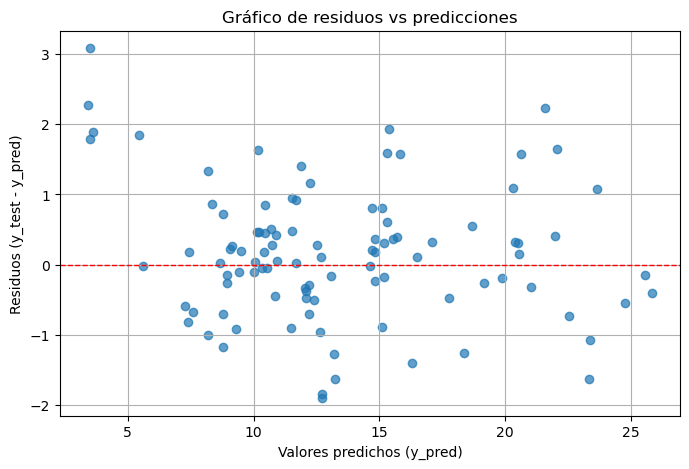

In [34]:
# Graficar residuos vs predicciones
import matplotlib.pyplot as plt

y_pred = mejor_modelo.predict(X_test)
residuos = y_test - y_pred

plt.figure(figsize=(8, 5))
plt.scatter(y_pred, residuos, alpha=0.7)
plt.axhline(0, color='red', linestyle='--', linewidth=1)
plt.title("Gráfico de residuos vs predicciones")
plt.xlabel("Valores predichos (y_pred)")
plt.ylabel("Residuos (y_test - y_pred)")
plt.grid(True)
plt.show()


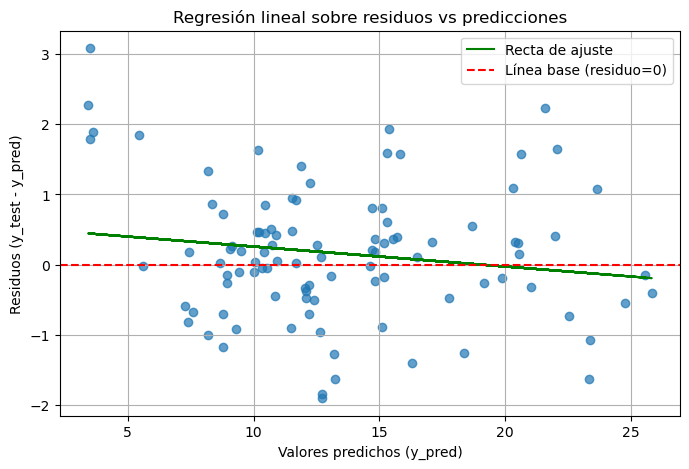

Pendiente: -0.028457372
Intercepto: 0.5402802
R² de la regresión de residuos: 0.02430904075535323


In [36]:
# 1. Importar librerías necesarias
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# 2. Calcular residuos
residuos = y_test - y_pred

# 3. Ajustar regresión lineal: residuos = β₀ + β₁ * y_pred
regresion_residuos = LinearRegression()
regresion_residuos.fit(y_pred.reshape(-1, 1), residuos)

# 4. Obtener pendiente e intercepto
pendiente = regresion_residuos.coef_[0]
intercepto = regresion_residuos.intercept_
r2_residuos = regresion_residuos.score(y_pred.reshape(-1, 1), residuos)

# 5. Graficar resultados
plt.figure(figsize=(8, 5))
plt.scatter(y_pred, residuos, alpha=0.7)
plt.plot(y_pred, regresion_residuos.predict(y_pred.reshape(-1, 1)), color='green', label='Recta de ajuste')
plt.axhline(y=0, color='red', linestyle='--', label='Línea base (residuo=0)')
plt.title('Regresión lineal sobre residuos vs predicciones')
plt.xlabel('Valores predichos (y_pred)')
plt.ylabel('Residuos (y_test - y_pred)')
plt.legend()
plt.grid(True)
plt.show()

# 6. Imprimir pendiente, intercepto y R²
print("Pendiente:", pendiente)
print("Intercepto:", intercepto)
print("R² de la regresión de residuos:", r2_residuos)


### Conclusiones sobre el comportamiento de residuos

**1. ¿Existe falta de linealidad en la respuesta?**

No parece haber una falta de linealidad evidente. Aunque la pendiente de la regresión sobre los residuos es negativa, su valor es pequeño (-0.028), lo que indica que **no hay una tendencia clara** en los errores conforme aumentan las predicciones. Además, el R² es muy bajo (≈ 0.02), lo que confirma que no se explica una variación lineal significativa

---

**2. ¿Hay correlación en los residuos?**

La pendiente ligeramente negativa podría insinuar una leve correlación entre los errores y las predicciones. Sin embargo, el **bajo R² (0.02)** indica que **la relación es muy débil**, lo que sugiere que los residuos están, en su mayoría, distribuidos de forma alsiduos.

---

**3. ¿Existe varianza no constante en los residuos (heterocedasticidad)?**

Visualmente, no hay una estructura en forma de cono (apertura o cierre en la dispersión de puntos) a lo largo del eje X. Los residuos parecen mantener una **dispersión más o menos uniforme**, sin ampliarse ni reducirse conforme cambian los valocedasticidad.

---

**4. ¿Se observan outliers?**

Sí, se notan varios puntos que se alejan mucho del eje horizontal (residuo = 0), tanto en la parte superior como inferior del gráfico. Estos puntos podrían representar **outliers** que afectan ligeramente la en un análisis más detallado.
más detallado.
